# 1. Import

In [2]:
%reset -f

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
import sys
from pathlib import Path
sys.path.append(str(Path.home()) + '/rpi-canary-eval/modules')

from path import path_dict, col_seq_cc, col_seq_elx
import data_process, data_functions, dowhy_methods
import numpy as np
import pandas as pd
from datetime import datetime
from functools import reduce
from sklearn import preprocessing
from datetime import timedelta, datetime
import seaborn as sns
import warnings
from dowhy import CausalModel
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.3f' % x)

/home/nneehal/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 2. Load PMPM Data and Process


In [5]:
# #### load pmpm data only
# _, _, pmpm = data_process.load_data(path_dict)

In [6]:
pmpm = pd.read_pickle('../temp/pmpm_ccm.p')

### 2A. Take log of cost

In [7]:
pmpm.ALLOW_AMT = pmpm.ALLOW_AMT.apply(data_process.log_)
pmpm.ALLOW_IP = pmpm.ALLOW_IP.apply(data_process.log_)
pmpm.ALLOW_ER = pmpm.ALLOW_ER.apply(data_process.log_)

In [8]:
pmpm = pmpm[(pmpm.MYR>=201701) & (pmpm.MYR<=201812)]

In [9]:
pmpm.head()

PERS_ID     MYR MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_IP  \
26898  2738219  201704        F               62      4.159     0.000   
26899  2739113  201704        M               62      7.440     0.000   
26900  2714219  201704        M               64      3.689     0.000   
26901  2714653  201704        M               64      3.871     0.000   
26902  2717373  201704        F               64      5.509     0.000   

       ALLOW_ER  CC_HYPOTHYROID  CC_AMI  CC_ALZHEIMER  ...  CC_HEPATITIS_A  \
26898     0.000               0       0             0  ...               0   
26899     0.000               0       1             0  ...               0   
26900     0.000               0       0             0  ...               0   
26901     0.000               0       0             0  ...               0   
26902     0.000               0       0             0  ...               0   

       CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  \
26898                     0                       0                     0   
26899                     0                       0                     0   
26900                     0                       0                     0   
26901                     0                       0                     0   
26902                     0                       0                     0   

       CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  \
26898                       0                           0               0   
26899                       0                           0               0   
26900                       0                           0               0   
26901                       0                           0               0   
26902                       0                           0               0   

       CC_HEPATITIS_E  CC_DX_CNT  CC_DISAB_DX_CNT  
26898               0          5                0  
26899               0         10                0  
26900               0          1                0  
26901               0          1                0  
26902               0          1                0  

[5 rows x 76 columns]

# 3. Training the Deep Neural Network

In [10]:
import data_generator

### 3A. Create Training Feature
col_seq_CC is the sequence of columns when using CC set of features - found in path.py in /modules

In [11]:
train_X = data_generator.generate_data(pmpm, 201701,201706, features=True, col_seq=col_seq_cc)

### 3B. Create Training Labels

In [12]:
train_Y = data_generator.generate_data(pmpm, 201801, 201806, features=True, col_seq=col_seq_cc)

### 3C. Intersect two data sets

In [13]:
train_X, train_Y = data_generator.make_intersection(train_X, train_Y)

### 3D. Creating Test Feature

In [14]:
test_X = data_generator.generate_data(pmpm, 201707,201712, features=True, col_seq=col_seq_cc)

### 3E. Creating Test Labels

In [15]:
test_Y = data_generator.generate_data(pmpm, 201807, 201812, features=True, col_seq=col_seq_cc)

### 3F. Intersect two data sets

In [16]:
test_X, test_Y = data_generator.make_intersection(test_X, test_Y)

In [17]:
train_X.shape, train_Y.shape, test_X.shape, test_Y.shape

In [18]:
del pmpm

### 3G. Define Model Architecture

In [19]:
import tensorflow as tf
from tensorflow import keras
from numpy import loadtxt
import tensorflow.keras.backend as K
import keras_model

/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type

In [20]:
baseline_model = keras_model.make_model_6(input_shape=train_X.shape[1])

In [21]:
baseline_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 74)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4800      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
representation (Dense)       (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
__________

### 3H. Model Fit

In [22]:
num_epochs = 20

#use this when multi-dim vectored output head
baseline_history = baseline_model.fit(train_X.values, train_Y.values, epochs=num_epochs, validation_split=0.1, batch_size=128, verbose=1)

Train on 313613 samples, validate on 34846 samples
Epoch 1/20
313613/313613 [==============================] - 7s 21us/step - loss: 3.3261 - mean_absolute_error: 0.5600 - val_loss: 2.2097 - val_mean_absolute_error: 0.3197
Epoch 2/20
313613/313613 [==============================] - 6s 19us/step - loss: 2.1174 - mean_absolute_error: 0.4200 - val_loss: 2.3516 - val_mean_absolute_error: 0.3151
Epoch 3/20
313613/313613 [==============================] - 6s 20us/step - loss: 1.9654 - mean_absolute_error: 0.4074 - val_loss: 2.4394 - val_mean_absolute_error: 0.3014
Epoch 4/20
313613/313613 [==============================] - 6s 20us/step - loss: 1.8738 - mean_absolute_error: 0.4017 - val_loss: 2.2362 - val_mean_absolute_error: 0.2948
Epoch 5/20
313613/313613 [==============================] - 6s 20us/step - loss: 1.8196 - mean_absolute_error: 0.3982 - val_loss: 1.9608 - val_mean_absolute_error: 0.2761
Epoch 6/20
313613/313613 [==============================] - 6s 20us/step - loss: 1.7949 - mean

In [23]:
baseline_history.history.keys()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])

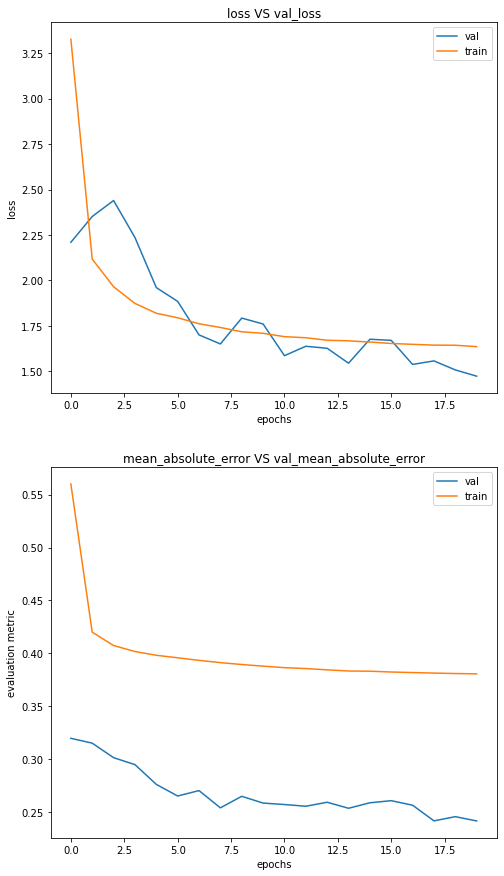

In [24]:
keras_model.plot_history(baseline_history, num_epochs, figsize=(8, 15))

In [25]:
print("Training Performance:",baseline_model.evaluate(train_X.values, train_Y.values))
print("Test Performance:",baseline_model.evaluate(test_X.values, test_Y.values))

348459/348459 [==============================] - 5s 14us/step
Training Performance: [3.0628182556162558, 0.398808246136115]
347817/347817 [==============================] - 5s 13us/step
Test Performance: [3.132369714696867, 0.40310047958196304]


### 3I. Latent Model upto Representation Layer

In [26]:
latent_model = tf.keras.Model(baseline_model.input, baseline_model.get_layer("representation").output)

In [27]:
pd.DataFrame(latent_model.predict(train_X))

0      1      2      3      4      5      6      7       8      9   \
0       0.465  0.382  3.092  0.073  0.301  3.649 -1.676 -1.981   2.936 -0.814   
1       0.249  0.291  2.379  0.007  0.228  2.727 -1.343 -1.546   2.257 -0.613   
2       5.527  0.389 11.407  5.544  1.982 13.166  4.994  5.640  -6.100 -1.226   
3       4.909 -0.300 15.177  5.161  3.004 16.903 -0.044 -0.351   2.411 -2.854   
4       4.907 -0.114  8.784  4.940  0.683 11.500  8.905  6.491 -10.533 -0.765   
...       ...    ...    ...    ...    ...    ...    ...    ...     ...    ...   
348454  0.032  0.161  1.153 -0.081  0.064  1.315 -0.707 -0.813   1.080 -0.256   
348455 -0.739 -0.048 -0.144 -0.427 -1.001 -0.011 -0.442  0.032   0.437 -0.356   
348456 -0.002  0.153  0.556  0.077 -0.055  0.818 -0.223 -0.257   0.283  0.015   
348457 -0.760 -0.050 -0.154 -0.446 -1.033 -0.007 -0.442  0.035   0.457 -0.374   
348458 -0.017  0.155  0.389  0.007 -0.086  0.591 -0.184 -0.199   0.184  0.028   

           10     11     12     13     14     15  
0      -0.093  0.238 -0.833  0.442  1.960 -2.650  
1      -0.078  0.147 -0.662  0.366  1.478 -2.049  
2       3.965 -0.240 -2.462 -6.691  2.735  2.809  
3       3.394  0.332 -3.214 -4.453  5.906 -2.371  
4       3.177 -0.209 -2.441 -6.278  1.180  5.632  
...       ...    ...    ...    ...    ...    ...  
348454 -0.042  0.089 -0.357  0.223  0.718 -1.022  
348455 -0.175 -0.033  0.285  0.438 -0.195  0.565  
348456  0.059  0.266 -0.275  0.019  0.354 -0.353  
348457 -0.173 -0.043  0.289  0.458 -0.203  0.582  
348458  0.045  0.223 -0.221  0.039  0.271 -0.289  

[348459 rows x 16 columns]

In [28]:
#freeze all the layers in both models
for layer in baseline_model.layers:
    layer.trainable=False
for layer in latent_model.layers:
    layer.trainable=False

### 3J. Save the Model

In [29]:
## save the models
baseline_model.save('../temp/TF_Full_Model_m6_CCM')
latent_model.save('../temp/TF_Latent_Model_m6_CCM')

In [30]:
#save in S3
import boto3
s3 = boto3.client('s3')
bucket = 'cdphp-s3-us-e-p-pond'
s3.upload_file( str(Path.home()) + '/rpi-canary-eval/temp/TF_Latent_Model_m6_CCM',
                bucket, 
                'rpi/nneehal/MODELS/TF_Latent_Model_m6_CCM',
                ExtraArgs = {'ACL':"bucket-owner-full-control", 'ServerSideEncryption':'AES256'})
s3.upload_file( str(Path.home()) + '/rpi-canary-eval/temp/TF_Full_Model_m6_CCM',
                bucket, 
                'rpi/nneehal/MODELS/TF_Full_Model_m6_CCM',
                ExtraArgs = {'ACL':"bucket-owner-full-control", 'ServerSideEncryption':'AES256'})